In [2]:
from mylib.statistic_test import *
# Gaussian smoothing
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

code_id = "0867 - Stability Under High Speed"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis") 
dir_name0 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")

        E:\Data\FinalResults\Dsp\0867 - Stability Under High Speed is already existed!


# R4

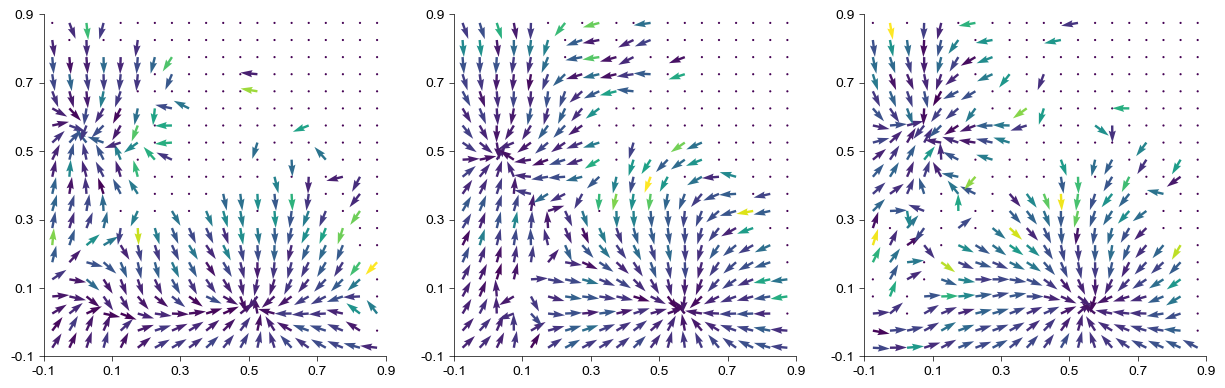

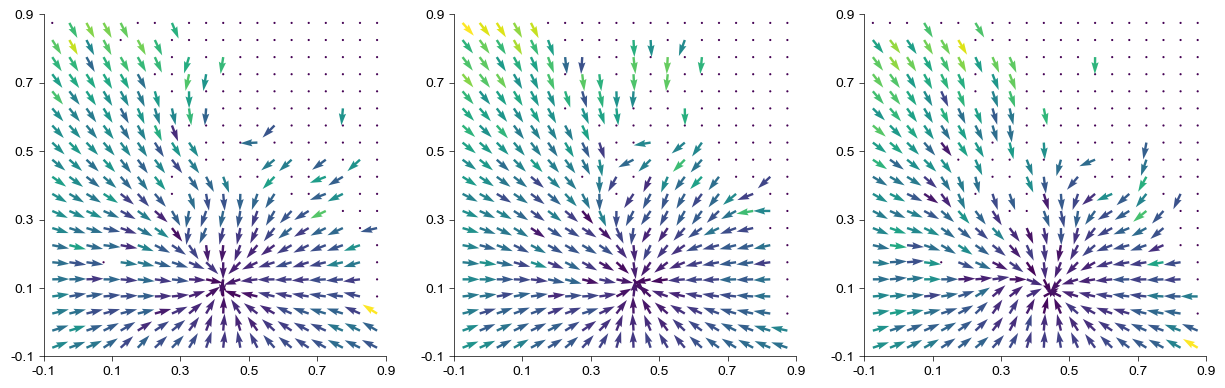

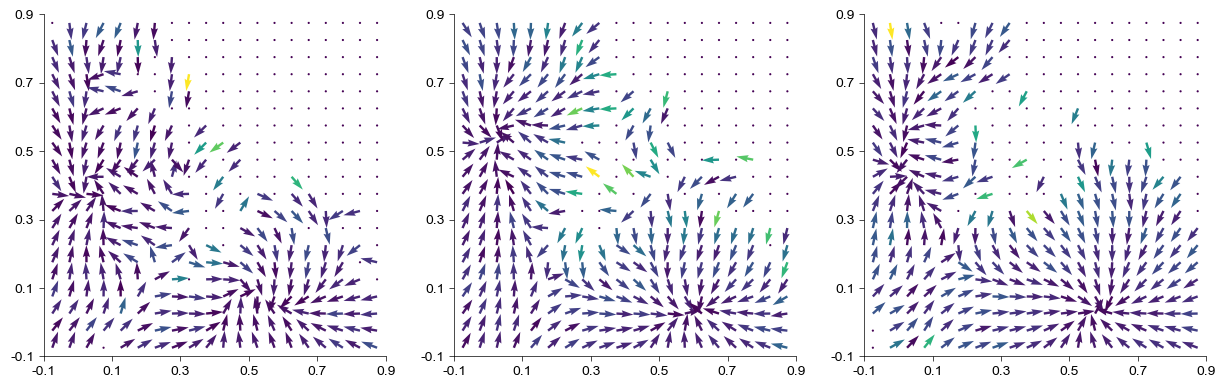

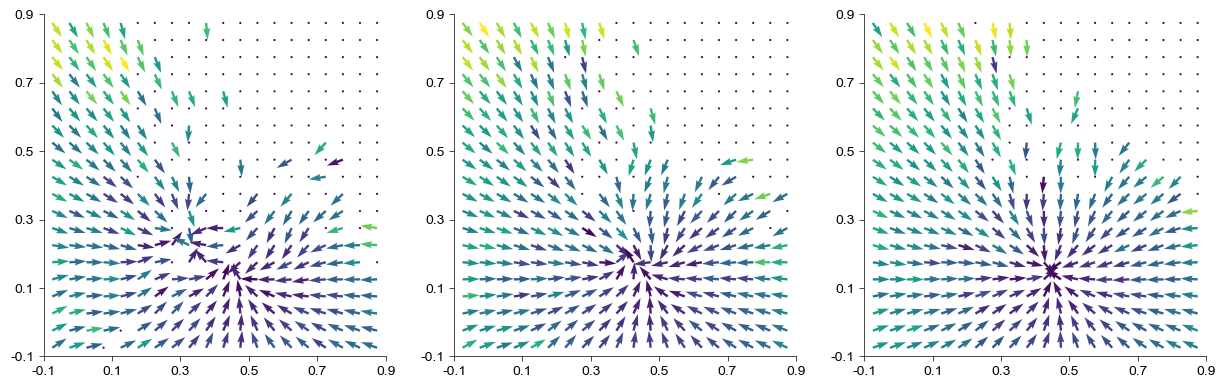

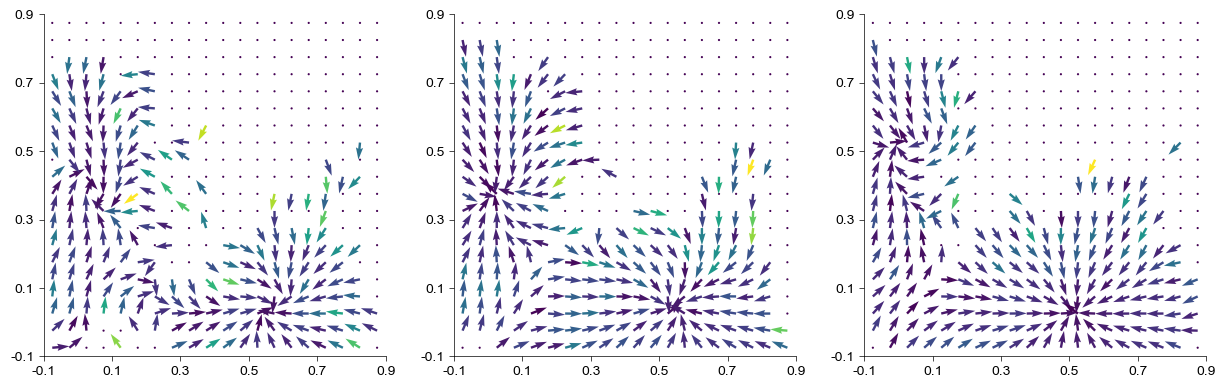

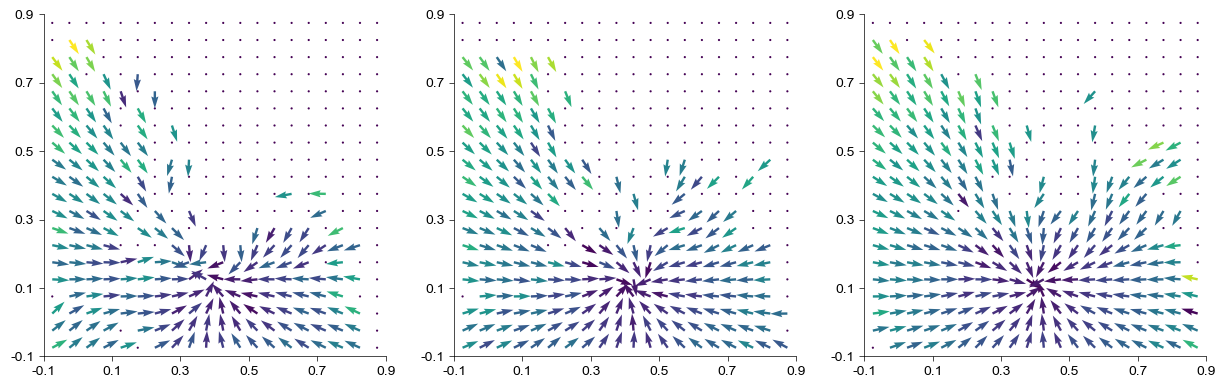

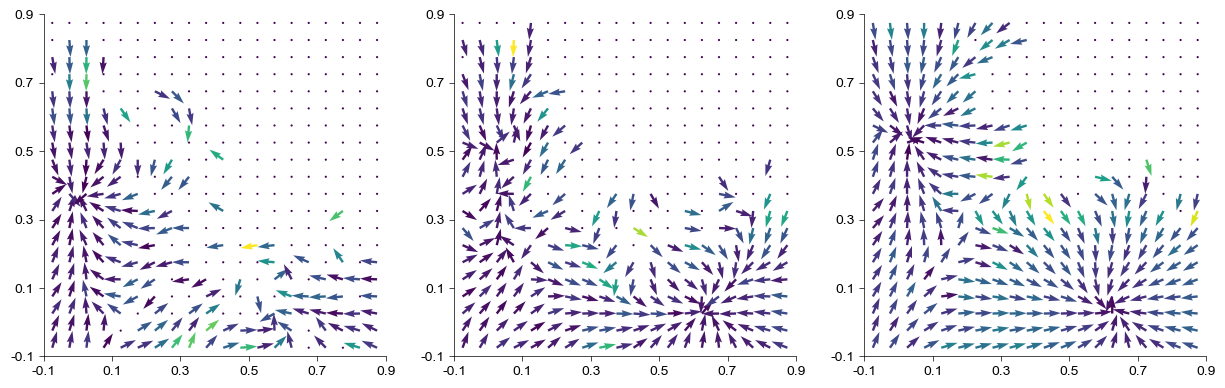

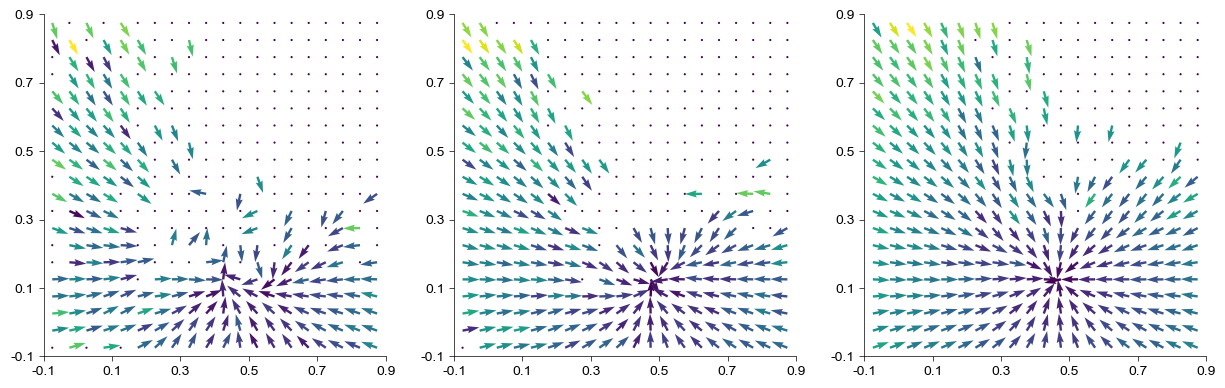

In [3]:
def process_data(mouse:int):
    if exists(join(loc, f"processed_{mouse}.pkl")):
        with open(join(loc, f"processed_{mouse}.pkl"), 'rb') as f:
            data = pickle.load(f)
    else:
        file_idx = np.where((f2['MiceID'] == mouse))[0]
        
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
            
        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as f:
            index_map = pickle.load(f).astype(np.int64)
            
        if mouse != 10232:
            index_map = index_map[1:, :] 
            
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
        print(X.shape)
        kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
        U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
        V0 = np.reshape(V[0, :], (CP_DSP[3].shape[0], -1))
        V1 = np.reshape(V[1, :], (CP_DSP[3].shape[0], -1))
        
        is_cell = np.where(index_map != 0, 1, 0)
        n_cells = np.sum(is_cell, axis=0)
        cell_idx = np.where(n_cells == 7)[0]
        
        data = {
            'neural_traj': [],
            'speed_traj': [],
            'corr_traj': [],
            'session_traj': [],
            'lap_traj': [],
            'route_traj': [],
            'pos_traj': [],
            'org_to_now_idx': []
        }
        print(mouse)
        for s in range(7):
            if s == 1 and mouse in [10212, 10227]:
                continue
            
            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace = pickle.load(f)  
                
            session_traj = res['session_traj']
            nodes_traj = res['pos_traj']
            father_nodes_traj = S2F[nodes_traj]-1
            idx = np.where((session_traj == s) & (np.isin(father_nodes_traj+1, CP_DSP[3])))[0]
            nodes_traj = nodes_traj[idx]
            father_nodes_traj = father_nodes_traj[idx]
            neural_traj = res['neural_traj'][:, idx]
            speed_traj = res['behav_params_traj'][8, res['behav_to_ms_traj']][idx]
            lap_traj = res['lap_traj'][idx]
            route_traj = res['route_traj'][idx]
        
            
            ratemap0 = np.mean(np.stack([
                trace[f'node {i}']['old_map_clear'][index_map[s, cell_idx]-1, :] for i in [0, 4, 5, 9]
            ], axis=2), axis=2)
            ratemap4 = trace[f'node {3}']['old_map_clear'][index_map[s, cell_idx]-1, :]
            
            corr_coord = np.zeros((route_traj.shape[0], 2))
            for i in tqdm(range(len(route_traj))):
                corr_coord[i, 0] = np.corrcoef(
                    neural_traj[:, i], 
                    ratemap0[:, father_nodes_traj[i]]
                )[0, 1]
                corr_coord[i, 1] = np.corrcoef(
                    neural_traj[:, i], 
                    ratemap4[:, father_nodes_traj[i]]
                )[0, 1]
            
            data['neural_traj'].append(neural_traj)
            data['speed_traj'].append(speed_traj)
            data['corr_traj'].append(corr_coord)
            data['session_traj'].append(session_traj[idx])
            data['lap_traj'].append(lap_traj)
            data['route_traj'].append(route_traj)
            data['pos_traj'].append(nodes_traj)
            data['org_to_now_idx'].append(idx)
            
        data['neural_traj'] = np.concatenate(data['neural_traj'], axis=1)
        data['speed_traj'] = np.concatenate(data['speed_traj'])
        data['corr_traj'] = np.concatenate(data['corr_traj'], axis=0).T
        data['session_traj'] = np.concatenate(data['session_traj'])
        data['lap_traj'] = np.concatenate(data['lap_traj'])
        data['route_traj'] = np.concatenate(data['route_traj'])
        data['pos_traj'] = np.concatenate(data['pos_traj'])
        data['org_to_now_idx'] = np.concatenate(data['org_to_now_idx'])
        
        with open(join(loc, f"processed_{mouse}.pkl"), 'wb') as f:
            pickle.dump(data, f)
    
    idx = np.where(
        (np.isnan(data['corr_traj'][0, :]) == False) &
        (np.isnan(data['corr_traj'][1, :]) == False)
    )[0]
    
    for k in data.keys():
        if data[k].ndim == 1:
            data[k] = data[k][idx]
        elif data[k].ndim == 2:
            data[k] = data[k][:, idx]
    
    return data

def plot_vector_field(mouse: int, is_shuf: bool = False):
    res = process_data(mouse)

    lap_traj = res['lap_traj']
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]])
    corr_traj = res['corr_traj']
    
    if is_shuf:
        
        rand_idx = np.random.permutation(corr_traj.shape[1])
        corr_traj = corr_traj[:, rand_idx]
    
    speed_traj = res['speed_traj']
    speed_binned = np.clip(speed_traj // 10, 0, 4).astype(np.int64)
    dcorr = np.zeros_like(corr_traj) * np.nan

    for i in range(len(beg)):
        dcorr[:, beg[i]:end[i]-1] = np.diff(corr_traj[:, beg[i]:end[i]], axis=1)

    x_binned = np.clip((corr_traj[0, :] + 0.1) // 0.05, 0, 19).astype(np.int64)
    y_binned = np.clip((corr_traj[1, :] + 0.1) // 0.05, 0, 19).astype(np.int64)

    avg_dcorr = np.zeros((20, 20, 5, 3))
    for sp in range(5):
        for i in range(20):
            for j in range(20):
            
                idx = np.where(
                    (x_binned == i) & 
                    (y_binned == j) & 
                    (speed_binned == sp) & 
                    (np.isnan(dcorr[0, :]) == False) &
                    (np.isnan(dcorr[1, :]) == False)
                )[0]
                if len(idx) > 0:
                    avg_dx = np.nanmean(dcorr[0, idx])
                    avg_dy = np.nanmean(dcorr[1, idx])
                    strength = np.sqrt(avg_dx**2 + avg_dy**2)
                    avg_dcorr[i, j, sp, 0] = avg_dx #/ strength if strength != 0 else 0
                    avg_dcorr[i, j, sp, 1] = avg_dy #/ strength if strength != 0 else 0
                    avg_dcorr[i, j, sp, 2] = strength
        
        idx0 = np.where(avg_dcorr[:, :, sp, 0] == 0)
        idx1 = np.where(avg_dcorr[:, :, sp, 1] == 0)
        avg_dcorr[:, :, sp, 0] = gaussian_filter(avg_dcorr[:, :, sp, 0], sigma=1)
        avg_dcorr[:, :, sp, 0][idx0] = 0
        avg_dcorr[:, :, sp, 1] = gaussian_filter(avg_dcorr[:, :, sp, 1], sigma=1)
        avg_dcorr[:, :, sp, 1][idx1] = 0
        strength = np.sqrt(
            avg_dcorr[:, :, sp, 0]**2 + avg_dcorr[:, :, sp, 1]**2
        )
        strength[strength < 1e-8] = 1e-8
        avg_dcorr[:, :, sp, 0] /= strength
        avg_dcorr[:, :, sp, 0][idx0] = 0
        avg_dcorr[:, :, sp, 1] /= strength
        avg_dcorr[:, :, sp, 1][idx1] = 0

    X, Y = np.meshgrid(np.arange(20), np.arange(20))

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
    sp = [0, 2, 4]
    for i in range(3):
        
        ax = Clear_Axes(axes[i], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
        ax.quiver(
            Y.flatten(), X.flatten(), 
            avg_dcorr[:, :, sp[i], 0].flatten(), 
            avg_dcorr[:, :, sp[i], 1].flatten(), 
            avg_dcorr[:, :, sp[i], 2],
            scale=20, width=0.007       
        )
        ax.set_xticks(np.linspace(-0.5, 19.5, 6), [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9])
        ax.set_yticks(np.linspace(-0.5, 19.5, 6), [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9])
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, 19.5)
        ax.set_ylim(-0.5, 19.5)
    
    plus = '' if is_shuf == False else ' (shuffled)'
    plt.savefig(join(loc, f"Example Vector Field [{mouse}{plus}].png"), dpi=600)
    plt.savefig(join(loc, f"Example Vector Field [{mouse}{plus}].svg"), dpi=600)
    plt.show()

for mouse in [10212, 10224, 10227, 10232]:
    #process_data(mouse)
    plot_vector_field(mouse, is_shuf=False)
    plot_vector_field(mouse, is_shuf=True)
    

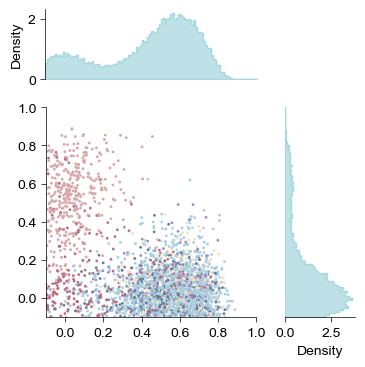

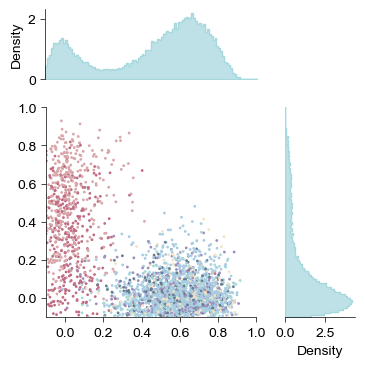

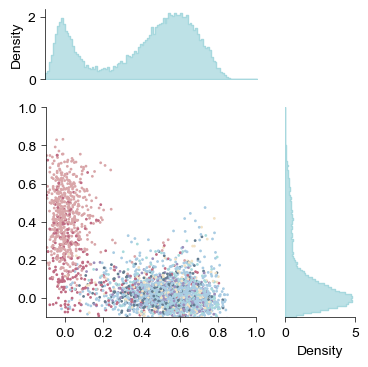

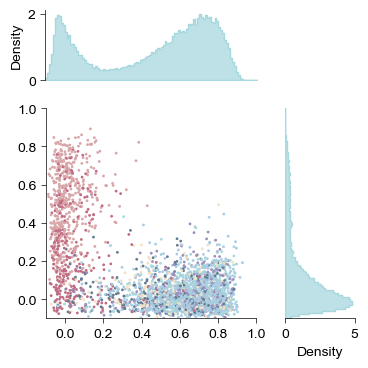

In [4]:
for mouse in [10212, 10224, 10227, 10232]:
    res = process_data(mouse)
    lap_traj = res['lap_traj']
    speed_traj = res['speed_traj']
    session_traj = res['session_traj']
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]])
    corr_traj = res['corr_traj']
    route_traj = res['route_traj']

    fig, axes = plt.subplots(
        ncols=2, nrows=2, figsize=(4, 4), 
        gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]}
    )
    ax = Clear_Axes(axes[1, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    # Set randdom seeds
    np.random.seed(42)
    rand_idx = np.random.choice(np.arange(corr_traj.shape[1]), size=3000, replace=False)
    ax.scatter(
        corr_traj[0, rand_idx], corr_traj[1, rand_idx], 
        s=1, c=DSPPaletteRGBA[route_traj[rand_idx], :],
        edgecolors=None
    )
    ax.set_aspect('equal')
    ax.axis([-0.1, 1, -0.1, 1])
    ax.set_xticks(np.linspace(0, 1, 6))

    Clear_Axes(axes[0, 1])

    ax0 = Clear_Axes(axes[0, 0], close_spines=['top', 'right', 'bottom'], ifyticks=True)
    sns.histplot(
        x=corr_traj[0, :], 
        bins=np.linspace(-0.1, 1, 111), 
        color=MicePaletteDSP[3],
        stat='density', 
        element='step',
        ax=ax0
    )
    ax0.set_xlim(-0.1, 1)

    ax1 = Clear_Axes(axes[1, 1], close_spines=['top', 'right', 'left'], ifxticks=True)
    sns.histplot(
        y=corr_traj[1, :], 
        bins=np.linspace(-0.1, 1, 111), 
        color=MicePaletteDSP[3],
        stat='density', 
        element='step',
        ax=ax1
    )
    ax1.set_ylim(-0.1, 1)
    plt.savefig(join(loc, f'Example Paired Correlation [{mouse}].png'), dpi=600)
    plt.savefig(join(loc, f'Example Paired Correlation [{mouse}].svg'), dpi=600)
    plt.show()

# Statistical Test

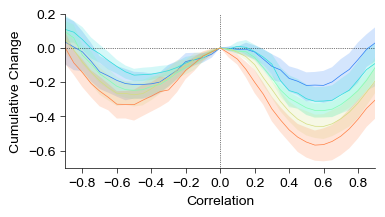

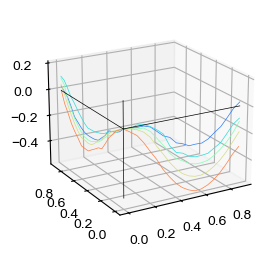

['R1' 'R4'] [-0.5  0.6]
R1: LinregressResult(slope=-0.0840591811015498, intercept=-0.2156148610080233, rvalue=-0.5726614209072515, pvalue=2.8509149546845518e-08, stderr=0.013625222228407131, intercept_stderr=0.03337484209162462)
R4: LinregressResult(slope=-0.0349873113254869, intercept=-0.17512506115640986, rvalue=-0.33169544743419443, pvalue=0.002649997629356312, stderr=0.011267133098264643, intercept_stderr=0.027598726954772092)


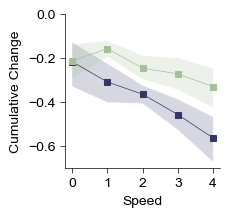

In [11]:
def get_data_for_speed(mouse: int, is_shuf: bool = False):
    res = process_data(mouse)
    
    lap_traj = res['lap_traj']
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]])
    corr_traj = res['corr_traj']
    
    if is_shuf:
        rand_idx = np.random.permutation(corr_traj.shape[1])
        corr_traj = corr_traj[:, rand_idx]
    
    speed_traj = res['speed_traj']
    speed_binned = np.clip(speed_traj // 10, 0, 4).astype(np.int64)
    dcorr = np.zeros_like(corr_traj) * np.nan

    for i in range(len(beg)):
        dcorr[:, beg[i]:end[i]-1] = np.diff(corr_traj[:, beg[i]:end[i]], axis=1)

    x_binned = np.clip((corr_traj[0, :] + 0.1) // 0.05, 0, 19).astype(np.int64)
    y_binned = np.clip((corr_traj[1, :] + 0.1) // 0.05, 0, 19).astype(np.int64)

    avg_dcorr = np.zeros((20, 20, 5, 3))
    for sp in range(5):
        for i in range(20):
            for j in range(20):
            
                idx = np.where(
                    (x_binned == i) & 
                    (y_binned == j) & 
                    (speed_binned == sp) & 
                    (np.isnan(dcorr[0, :]) == False) &
                    (np.isnan(dcorr[1, :]) == False)
                )[0]
                if len(idx) > 0:
                    avg_dx = np.nanmean(dcorr[0, idx])
                    avg_dy = np.nanmean(dcorr[1, idx])
                    strength = np.sqrt(avg_dx**2 + avg_dy**2)
                    avg_dcorr[i, j, sp, 0] = avg_dx #/ strength if strength != 0 else 0
                    avg_dcorr[i, j, sp, 1] = avg_dy #/ strength if strength != 0 else 0
                    avg_dcorr[i, j, sp, 2] = strength

        idx0 = np.where(avg_dcorr[:, :, sp, 0] == 0)
        idx1 = np.where(avg_dcorr[:, :, sp, 1] == 0)
        avg_dcorr[:, :, sp, 0] = gaussian_filter(avg_dcorr[:, :, sp, 0], sigma=0.01)
        avg_dcorr[:, :, sp, 0][idx0] = 0
        avg_dcorr[:, :, sp, 1] = gaussian_filter(avg_dcorr[:, :, sp, 1], sigma=0.01)
        avg_dcorr[:, :, sp, 1][idx1] = 0
        strength = np.sqrt(
            avg_dcorr[:, :, sp, 0]**2 + avg_dcorr[:, :, sp, 1]**2
        )
        strength[strength < 1e-8] = 1e-8
        avg_dcorr[:, :, sp, 0] /= strength
        avg_dcorr[:, :, sp, 0][idx0] = 0
        avg_dcorr[:, :, sp, 1] /= strength
        avg_dcorr[:, :, sp, 1][idx1] = 0
        avg_dcorr[:, :, sp, 2] = strength
        
        
    x = []
    y = []
    comparison = []
    speed = []
    
    for sp in range(5):
        for i in range(4):
            x.append(np.linspace(0, 0.9, 19))
            cumsum = np.concatenate([[0], np.cumsum(-avg_dcorr[2:, i, sp, 2] * avg_dcorr[2:, i, sp, 0])])
            y.append(cumsum)
            comparison.append(np.repeat('R1', 19))
            speed.append(np.repeat(sp, 19))
            
            x.append(np.linspace(0, 0.9, 19))
            cumsum = np.concatenate([[0], np.cumsum(-avg_dcorr[i, 2:, sp, 2] * avg_dcorr[i, 2:, sp, 1])])
            y.append(cumsum)
            comparison.append(np.repeat('R4', 19))
            speed.append(np.repeat(sp, 19))
            
    x = np.concatenate(x)
    y = np.concatenate(y)
    comparison = np.concatenate(comparison)
    speed = np.concatenate(speed)
    return x, y, comparison, speed

if exists(join(figdata, f"{code_id} [Attractor for Speed].pkl")) == False:
    AttractorSpeed = {
        "MiceID": [],
        "Correlation": [],
        "Cumulative Change": [],
        "Comparison": [],
        "Speed": [],
        "Type": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for is_shuf in [False, True]:
            x, y, comparison, speed = get_data_for_speed(mouse, is_shuf)
            AttractorSpeed["MiceID"].append(np.repeat(mouse, len(x)))
            AttractorSpeed["Correlation"].append(x)
            AttractorSpeed["Cumulative Change"].append(y)
            AttractorSpeed["Comparison"].append(comparison)
            AttractorSpeed["Speed"].append(speed)
            AttractorSpeed["Type"].append(np.repeat('Shuffled' if is_shuf else 'Data', len(x)))
    
    for k in AttractorSpeed.keys():
        AttractorSpeed[k] = np.concatenate(AttractorSpeed[k])
        
    with open(join(figdata, f"{code_id} [Attractor for Speed].pkl"), 'wb') as f:
        pickle.dump(AttractorSpeed, f)
    
    AttractorSpeedD = pd.DataFrame(AttractorSpeed)
    AttractorSpeedD.to_excel(join(figdata, f"{code_id} [Attractor for Speed].xlsx"), index=False)
    print(len(AttractorSpeedD))
else:
    with open(join(figdata, f"{code_id} [Attractor for Speed].pkl"), 'rb') as f:
        AttractorSpeed = pickle.load(f)
        
AttractorSpeed['Hue'] = np.array([
    "Shuffle" if AttractorSpeed['Type'][i] == 'Shuffled' else f"{AttractorSpeed['Speed'][i]}"
    for i in range(len(AttractorSpeed['Type']))
])
AttractorSpeed['Correlation'][AttractorSpeed['Comparison'] == 'R4'] *= -1

SubData = SubDict(
    AttractorSpeed,
    AttractorSpeed.keys(),
    np.where(AttractorSpeed['Type'] != 'Shuffled')[0]
)
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks =True, ifyticks=True)
ax.axhline(0, ls=':', lw=0.5, c='k')
ax.axvline(0, ls=':', lw=0.5, c='k')
sns.lineplot(
    x='Correlation',
    y='Cumulative Change',
    hue='Hue',
    data=SubData,
    palette=sns.color_palette("rainbow", n_colors=5) + ['k'],
    hue_order=[str(i) for i in range(5)] + ['Shuffle'],
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax.set_ylim(-0.7, 0.2)
ax.set_xticks(np.linspace(-1, 1, 11))
ax.set_xlim(-0.9, 0.9)
plt.savefig(join(loc, "Attractor for Speed.png"), dpi=600)
plt.savefig(join(loc, "Attractor for Speed.svg"), dpi=600)
plt.show()

colors = sns.color_palette("rainbow", n_colors=5)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
for s in range(5):

    
    x = np.linspace(0, 0.9, 19)
    y = np.zeros_like(x)
    z1 = np.zeros_like(x)
    z4 = np.zeros_like(x)
    for i in range(len(x)):
        idx1 = np.where(
            (SubData['Speed'] == s) & 
            (SubData['Correlation'] == x[i])
        )[0]  
    
        idx4 = np.where(
            (SubData['Speed'] == s) & 
            (SubData['Correlation'] == -x[i])
        )[0] 
         
        z1[i] = np.nanmean(SubData['Cumulative Change'][idx1])
        z4[i] = np.nanmean(SubData['Cumulative Change'][idx4])
        
    ax.plot(x, y, z1, color=colors[s], lw=0.5)
    ax.plot(y, x, z4, color=colors[s], lw=0.5)
# Change view
ax.view_init(elev=20, azim=-120)
ax.plot([0, 0], [0, 0], [-0.5, 0.2], lw=0.5, c='k')
ax.plot([0, 0], [0, 0.9], [0, 0], lw=0.5, c='k')
ax.plot([0, 0.9], [0, 0], [0, 0], lw=0.5, c='k')
plt.savefig(join(loc, "Attractor for Speed [3d].png"), dpi=600)
plt.savefig(join(loc, "Attractor for Speed [3d].svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(2, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks =True, ifyticks=True)
SubData = SubDict(
    AttractorSpeed,
    AttractorSpeed.keys(),
    np.where(
        ((np.abs(AttractorSpeed['Correlation'] - -0.5) < 1e-3) |
         (np.abs(AttractorSpeed['Correlation'] - 0.6) < 1e-3)) &
        (AttractorSpeed['Type'] != 'Shuffled')
    )[0]
)
print(np.unique(SubData['Comparison']), np.unique(SubData['Correlation']))
sns.lineplot(
    x='Speed',
    y='Cumulative Change',
    hue='Comparison',
    data=SubData,
    palette=RemappingPalette,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False,
    marker='s',
    markersize=5,
    markeredgecolor=None,
    ax=ax
)
ax.set_ylim(-0.7, 0)
ax.set_xticks(np.arange(5))
idx_m0 = np.where(SubData['Comparison'] == 'R1')[0]
idx_m4 = np.where(SubData['Comparison'] == 'R4')[0]
print(f"R1: {linregress(SubData['Speed'][idx_m0], SubData['Cumulative Change'][idx_m0])}")
print(f"R4: {linregress(SubData['Speed'][idx_m4], SubData['Cumulative Change'][idx_m4])}")
plt.savefig(join(loc, "Attractor for Speed [Stat].png"), dpi=600)
plt.savefig(join(loc, "Attractor for Speed [Stat].svg"), dpi=600)
plt.show()

# For Session

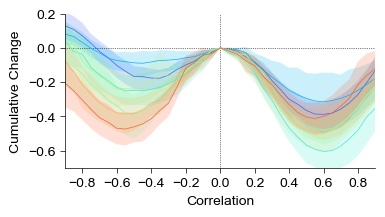

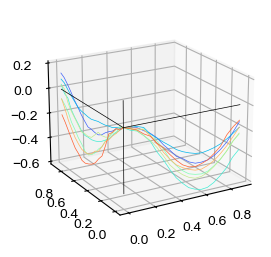

['R1' 'R4'] [-0.5  0.6]
R1: LinregressResult(slope=-0.006749825923018172, intercept=-0.42748295960799915, rvalue=-0.056348863223698614, pvalue=0.5551105558456721, stderr=0.011403035839503934, intercept_stderr=0.04111423041528499)
R4: LinregressResult(slope=-0.05234713933609179, intercept=-0.12527555469324492, rvalue=-0.4675826002551798, pvalue=2.016045326238879e-07, stderr=0.009435516232028412, intercept_stderr=0.03402023758505121)


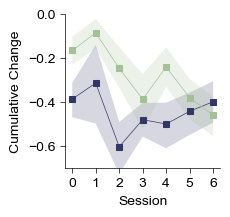

In [12]:
def get_data_for_session(mouse: int, is_shuf: bool = False):
    res = process_data(mouse)
    
    lap_traj = res['lap_traj']
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]])
    corr_traj = res['corr_traj']
    session_traj = res['session_traj']
    
    if is_shuf:
        rand_idx = np.random.permutation(corr_traj.shape[1])
        corr_traj = corr_traj[:, rand_idx]
    
    speed_traj = res['speed_traj']
    speed_binned = np.clip(speed_traj // 10, 0, 4).astype(np.int64)
    dcorr = np.zeros_like(corr_traj) * np.nan

    for i in range(len(beg)):
        dcorr[:, beg[i]:end[i]-1] = np.diff(corr_traj[:, beg[i]:end[i]], axis=1)

    x_binned = np.clip((corr_traj[0, :] + 0.1) // 0.05, 0, 19).astype(np.int64)
    y_binned = np.clip((corr_traj[1, :] + 0.1) // 0.05, 0, 19).astype(np.int64)

    avg_dcorr = np.zeros((20, 20, 7, 3))
    for s in range(7):
        for i in range(20):
            for j in range(20):
            
                idx = np.where(
                    (x_binned == i) & 
                    (y_binned == j) & 
                    (session_traj == s) & 
                    (np.isnan(dcorr[0, :]) == False) &
                    (np.isnan(dcorr[1, :]) == False)
                )[0]
                if len(idx) > 0:
                    avg_dx = np.nanmean(dcorr[0, idx])
                    avg_dy = np.nanmean(dcorr[1, idx])
                    strength = np.sqrt(avg_dx**2 + avg_dy**2)
                    avg_dcorr[i, j, s, 0] = avg_dx #/ strength if strength != 0 else 0
                    avg_dcorr[i, j, s, 1] = avg_dy #/ strength if strength != 0 else 0
                    avg_dcorr[i, j, s, 2] = strength

        idx0 = np.where(avg_dcorr[:, :, s, 0] == 0)
        idx1 = np.where(avg_dcorr[:, :, s, 1] == 0)
        avg_dcorr[:, :, s, 0] = gaussian_filter(avg_dcorr[:, :, s, 0], sigma=0.01)
        avg_dcorr[:, :, s, 0][idx0] = 0
        avg_dcorr[:, :, s, 1] = gaussian_filter(avg_dcorr[:, :, s, 1], sigma=0.01)
        avg_dcorr[:, :, s, 1][idx1] = 0
        strength = np.sqrt(
            avg_dcorr[:, :, s, 0]**2 + avg_dcorr[:, :, s, 1]**2
        )
        strength[strength < 1e-8] = 1e-8
        avg_dcorr[:, :, s, 0] /= strength
        avg_dcorr[:, :, s, 0][idx0] = 0
        avg_dcorr[:, :, s, 1] /= strength
        avg_dcorr[:, :, s, 1][idx1] = 0
        avg_dcorr[:, :, s, 2] = strength
        
        
    x = []
    y = []
    comparison = []
    session = []
    
    for s in range(7):
        for i in range(4):
            x.append(np.linspace(0, 0.9, 19))
            cumsum = np.concatenate([[0], np.cumsum(-avg_dcorr[2:, i, s, 2] * avg_dcorr[2:, i, s, 0])])
            y.append(cumsum)
            comparison.append(np.repeat('R1', 19))
            session.append(np.repeat(s, 19))
            
            x.append(np.linspace(0, 0.9, 19))
            cumsum = np.concatenate([[0], np.cumsum(-avg_dcorr[i, 2:, s, 2] * avg_dcorr[i, 2:, s, 1])])
            y.append(cumsum)
            comparison.append(np.repeat('R4', 19))
            session.append(np.repeat(s, 19))
            
    x = np.concatenate(x)
    y = np.concatenate(y)
    comparison = np.concatenate(comparison)
    session = np.concatenate(session)
    return x, y, comparison, session

if exists(join(figdata, f"{code_id} [Attractor for Session].pkl")) == False:
    AttractorSession = {
        "MiceID": [],
        "Correlation": [],
        "Cumulative Change": [],
        "Comparison": [],
        "Session": [],
        "Type": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for is_shuf in [False, True]:
            x, y, comparison, session = get_data_for_session(mouse, is_shuf)
            AttractorSession["MiceID"].append(np.repeat(mouse, len(x)))
            AttractorSession["Correlation"].append(x)
            AttractorSession["Cumulative Change"].append(y)
            AttractorSession["Comparison"].append(comparison)
            AttractorSession["Session"].append(session)
            AttractorSession["Type"].append(np.repeat('Shuffled' if is_shuf else 'Data', len(x)))
    
    for k in AttractorSession.keys():
        AttractorSession[k] = np.concatenate(AttractorSession[k])
        
    with open(join(figdata, f"{code_id} [Attractor for Session].pkl"), 'wb') as f:
        pickle.dump(AttractorSession, f)
    
    AttractorSessionD = pd.DataFrame(AttractorSession)
    AttractorSessionD.to_excel(join(figdata, f"{code_id} [Attractor for Session].xlsx"), index=False)
    print(len(AttractorSessionD))
else:
    with open(join(figdata, f"{code_id} [Attractor for Session].pkl"), 'rb') as f:
        AttractorSession = pickle.load(f)
        
AttractorSession['Hue'] = np.array([
    "Shuffle" if AttractorSession['Type'][i] == 'Shuffled' else f"{AttractorSession['Session'][i]}"
    for i in range(len(AttractorSession['Type']))
])
AttractorSession['Correlation'][AttractorSession['Comparison'] == 'R4'] *= -1

SubData = SubDict(
    AttractorSession,
    AttractorSession.keys(),
    np.where(AttractorSession['Type'] != 'Shuffled')[0]
)
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks =True, ifyticks=True)
ax.axhline(0, ls=':', lw=0.5, c='k')
ax.axvline(0, ls=':', lw=0.5, c='k')
sns.lineplot(
    x='Correlation',
    y='Cumulative Change',
    hue='Hue',
    data=SubData,
    palette=sns.color_palette("rainbow", n_colors= 7) + ['k'],
    hue_order=[str(i) for i in range(7)] + ['Shuffle'],
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax.set_ylim(-0.7, 0.2)
ax.set_xticks(np.linspace(-1, 1, 11))
ax.set_xlim(-0.9, 0.9)
plt.savefig(join(loc, "Attractor for Session.png"), dpi=600)
plt.savefig(join(loc, "Attractor for Session.svg"), dpi=600)
plt.show()

colors = sns.color_palette("rainbow", n_colors=7)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
for s in range(7):
    x = np.linspace(0, 0.9, 19)
    y = np.zeros_like(x)
    z1 = np.zeros_like(x)
    z4 = np.zeros_like(x)
    for i in range(len(x)):
        idx1 = np.where(
            (SubData['Session'] == s) & 
            (SubData['Correlation'] == x[i])
        )[0]  
    
        idx4 = np.where(
            (SubData['Session'] == s) & 
            (SubData['Correlation'] == -x[i])
        )[0] 
         
        z1[i] = np.nanmean(SubData['Cumulative Change'][idx1])
        z4[i] = np.nanmean(SubData['Cumulative Change'][idx4])
        
    ax.plot(x, y, z1, color=colors[s], lw=0.5)
    ax.plot(y, x, z4, color=colors[s], lw=0.5)
# Change view
ax.view_init(elev=20, azim=-120)
ax.plot([0, 0], [0, 0], [-0.5, 0.2], lw=0.5, c='k')
ax.plot([0, 0], [0, 0.9], [0, 0], lw=0.5, c='k')
ax.plot([0, 0.9], [0, 0], [0, 0], lw=0.5, c='k')
plt.savefig(join(loc, "Attractor for Session [3d].png"), dpi=600)
plt.savefig(join(loc, "Attractor for Session [3d].svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(2, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks =True, ifyticks=True)
SubData = SubDict(
    AttractorSession,
    AttractorSession.keys(),
    np.where(
        ((np.abs(AttractorSession['Correlation'] - -0.5) < 1e-3) |
         (np.abs(AttractorSession['Correlation'] - 0.6) < 1e-3)) &
        (AttractorSession['Type'] != 'Shuffled')
    )[0]
)
print(np.unique(SubData['Comparison']), np.unique(SubData['Correlation']))
sns.lineplot(
    x='Session',
    y='Cumulative Change',
    hue='Comparison',
    data=SubData,
    palette=RemappingPalette,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False,
    marker='s',
    markersize=5,
    markeredgecolor=None,
    ax=ax
)
ax.set_ylim(-0.7, 0)
ax.set_xticks(np.arange(7))
idx_m0 = np.where(SubData['Comparison'] == 'R1')[0]
idx_m4 = np.where(SubData['Comparison'] == 'R4')[0]
print(f"R1: {linregress(SubData['Session'][idx_m0], SubData['Cumulative Change'][idx_m0])}")
print(f"R4: {linregress(SubData['Session'][idx_m4], SubData['Cumulative Change'][idx_m4])}")
plt.savefig(join(loc, "Attractor for Session [Stat].png"), dpi=600)
plt.savefig(join(loc, "Attractor for Session [Stat].svg"), dpi=600)
plt.show()

# Example Lap On Attractor Map

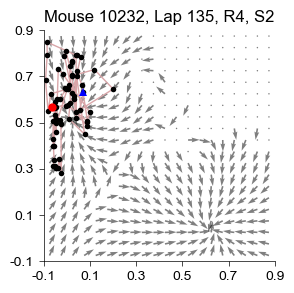

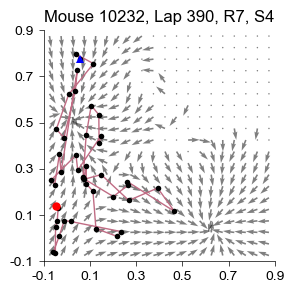

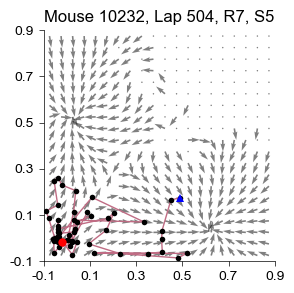

In [27]:
def plot_lap_on_vector_field(mouse: int, is_shuf: bool = False):
    res = process_data(mouse)

    lap_traj = res['lap_traj']
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]])
    corr_traj = res['corr_traj']
    route_traj = res['route_traj']
    session_traj = res['session_traj']
    
    if is_shuf:
        
        rand_idx = np.random.permutation(corr_traj.shape[1])
        corr_traj = corr_traj[:, rand_idx]
    
    speed_traj = res['speed_traj']
    speed_binned = np.clip(speed_traj // 10, 0, 4).astype(np.int64)
    dcorr = np.zeros_like(corr_traj) * np.nan

    for i in range(len(beg)):
        dcorr[:, beg[i]:end[i]-1] = np.diff(corr_traj[:, beg[i]:end[i]], axis=1)

    x_binned = np.clip((corr_traj[0, :] + 0.1) // 0.05, 0, 19).astype(np.int64)
    y_binned = np.clip((corr_traj[1, :] + 0.1) // 0.05, 0, 19).astype(np.int64)

    avg_dcorr = np.zeros((20, 20, 3))
    for i in range(20):
        for j in range(20):
            
            idx = np.where(
                (x_binned == i) & 
                (y_binned == j) & 
                (np.isnan(dcorr[0, :]) == False) &
                (np.isnan(dcorr[1, :]) == False)
            )[0]
            if len(idx) > 0:
                avg_dx = np.nanmean(dcorr[0, idx])
                avg_dy = np.nanmean(dcorr[1, idx])
                strength = np.sqrt(avg_dx**2 + avg_dy**2)
                avg_dcorr[i, j, 0] = avg_dx #/ strength if strength != 0 else 0
                avg_dcorr[i, j, 1] = avg_dy #/ strength if strength != 0 else 0
                avg_dcorr[i, j, 2] = strength
        
    idx0 = np.where(avg_dcorr[:, :, 0] == 0)
    idx1 = np.where(avg_dcorr[:, :, 1] == 0)
    avg_dcorr[:, :, 0] = gaussian_filter(avg_dcorr[:, :, 0], sigma=1)
    avg_dcorr[:, :, 0][idx0] = 0
    avg_dcorr[:, :, 1] = gaussian_filter(avg_dcorr[:, :, 1], sigma=1)
    avg_dcorr[:, :, 1][idx1] = 0
    strength = np.sqrt(
        avg_dcorr[:, :, 0]**2 + avg_dcorr[:, :, 1]**2
    )
    strength[strength < 1e-8] = 1e-8
    avg_dcorr[:, :, 0] /= strength
    avg_dcorr[:, :, 0][idx0] = 0
    avg_dcorr[:, :, 1] /= strength
    avg_dcorr[:, :, 1][idx1] = 0

    X, Y = np.meshgrid(np.arange(20), np.arange(20))

    for l in np.array([135, 390, 504])-1:
        if route_traj[beg[l]] not in [3, 6]:
            continue
        
        fig = plt.figure(figsize=(3, 3))
        ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
        ax.quiver(
            Y.flatten(), X.flatten(), 
            avg_dcorr[:, :, 0].flatten(), 
            avg_dcorr[:, :, 1].flatten(), 
            color='k', alpha=0.5,
            scale=20, width=0.007       
        )
        ax.set_xticks(np.linspace(-0.5, 19.5, 6), [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9])
        ax.set_yticks(np.linspace(-0.5, 19.5, 6), [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9])
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, 19.5)
        ax.set_ylim(-0.5, 19.5)
        
        ax.plot(
            (corr_traj[0, beg[l]:end[l]]+0.1)*20-0.5, 
            (corr_traj[1, beg[l]:end[l]]+0.1)*20-0.5, 
            marker='o', markersize=4,
            markeredgewidth=0,
            markerfacecolor='k',
            lw=1, c=DSPPalette[route_traj[beg[l]]]
        )
        ax.plot(
            (corr_traj[0, beg[l]:beg[l]+1]+0.1)*20-0.5, 
            (corr_traj[1, beg[l]:beg[l]+1]+0.1)*20-0.5, 
            c='red', marker='o', markersize=6, markeredgewidth=0
        )
        ax.plot(
            (corr_traj[0, end[l]-1:end[l]]+0.1)*20-0.5, 
            (corr_traj[1, end[l]-1:end[l]]+0.1)*20-0.5, 
            c='blue', marker='^', markersize=6, markeredgewidth=0
        )
        ax.set_title(f"Mouse {mouse}, Lap {l+1}, R{route_traj[beg[l]]+1}, S{session_traj[beg[l]]+1}")
        plt.savefig(join(loc, f"Example Lap [{mouse} L{l+1}].png"), dpi=600)
        plt.savefig(join(loc, f"Example Lap [{mouse} L{l+1}]].svg"), dpi=600)
        plt.show()

plot_lap_on_vector_field(10232)
    

# To Diagonal Distances vs. Speed and Session